## Подготовка данных и раздведовательный анализ

In [65]:
# imports
import pandas as pd
import numpy as np

#### Константы
- путь к данным
- признаки, описывающие состояние ТС

In [3]:
DATA_PATH = 'data/vehicle_dataset_public/'

TAGS = ['fuelLevel', 'ingection', 'refueling2',
        'speedAndHeight', 'tachometer']

In [169]:
def dict_df_vehicle_i(i):
    dict_df_vehicle = {}
    for tag in TAGS:
        dict_df_vehicle[tag] = pd.read_csv(DATA_PATH +
                                            f'vehicle{i}_{tag}_public.csv', sep=';')
    return dict_df_vehicle

In [170]:
dict_df = dict_df_vehicle_i(1)

In [171]:
dict_df.keys()

dict_keys(['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer'])

In [172]:
ref_df = dict_df['refueling2'].copy()

In [173]:
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,"46,7","38,4"
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,"38,4","56,7"
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,"56,3",51
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51,"43,9"
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,"43,9","23,5"


In [174]:
float_columns = ['STARTLEVEL', 'ENDLEVEL']

for col in float_columns:
    ref_df[col] = ref_df[col].str.replace(',', '.').astype(float)

datetime_columns = ['STARTDATE', 'ENDDATE']

for col in datetime_columns:
    ref_df[col] = pd.to_datetime(ref_df[col])

In [175]:
ref_df['duration'] = ref_df['ENDDATE'] - ref_df['STARTDATE']
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4,02:18:00
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7,00:05:06
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0,03:08:21
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9,01:26:39
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5,03:00:04


In [176]:
ref_df['duration'].describe()

count                       103
mean     0 days 01:32:47.621359
std      0 days 01:12:55.148053
min             0 days 00:01:00
25%      0 days 00:08:39.500000
50%             0 days 01:40:27
75%      0 days 02:32:39.500000
max             0 days 03:50:23
Name: duration, dtype: object

In [177]:
duration_components = ref_df['duration'].dt.components[['hours', 'minutes', 'seconds']]
duration_components.head()

,hours,minutes,seconds
0,2,18,0
1,0,5,6
2,3,8,21
3,1,26,39
4,3,0,4


In [178]:
# длительность в минутах
ref_df['duration_minutes'] = np.dot(duration_components, [60, 1, 1/60])
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration,duration_minutes
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4,02:18:00,138.000000
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7,00:05:06,5.100000
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0,03:08:21,188.350000
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9,01:26:39,86.650000
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5,03:00:04,180.066667


In [179]:
# скорость изменения объема топлива
ref_df['LPM'] = (ref_df['ENDLEVEL'] - ref_df['STARTLEVEL']) / ref_df['duration_minutes'] # liters per minute
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration,duration_minutes,LPM
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4,02:18:00,138.000000,-0.060145
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7,00:05:06,5.100000,3.588235
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0,03:08:21,188.350000,-0.028139
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9,01:26:39,86.650000,-0.081939
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5,03:00:04,180.066667,-0.113291


In [180]:
ref_df['LPM'].describe()

count    103.000000
mean       2.709313
std        6.103922
min       -0.201195
25%       -0.084062
50%       -0.060791
75%        3.628202
max       38.100000
Name: LPM, dtype: float64

In [181]:
import seaborn as sns

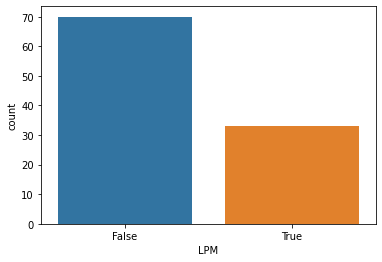

In [182]:
# Заправка/слив
sns.countplot(ref_df['LPM'] > 0)

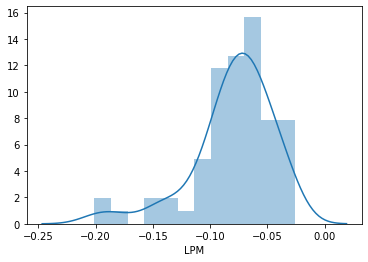

In [183]:
# Это, как я понимаю, сливы
# Интересно, с какой скоростью топливо расходуется при движении
sns.distplot(ref_df.loc[ref_df['LPM'] < 0, 'LPM'])

In [184]:
# Теперь для всех ТС

In [185]:
def process_refueling_df(df):
    ref_df = df.copy()
    
    float_columns = ['STARTLEVEL', 'ENDLEVEL']
    
    for col in float_columns:
        if ref_df[col].dtype == 'object':
            ref_df[col] = ref_df[col].str.replace(',', '.').astype(float)
    
    datetime_columns = ['STARTDATE', 'ENDDATE']

    for col in datetime_columns:
        ref_df[col] = pd.to_datetime(ref_df[col])
    
    ref_df['duration'] = ref_df['ENDDATE'] - ref_df['STARTDATE']
    
    duration_components = ref_df['duration'].dt.components[['hours', 'minutes', 'seconds']]
    
    ref_df['duration_minutes'] = np.dot(duration_components, [60, 1, 1/60])
    
    ref_df['LPM'] = (ref_df['ENDLEVEL'] - ref_df['STARTLEVEL']) / ref_df['duration_minutes']
    
    return ref_df

In [195]:
vehicle_ids = [1, 3, 5, 19, 28]

ref_dfs = {}

for vehicle_id in vehicle_ids:
    dict_df = dict_df_vehicle_i(vehicle_id)
    
    ref_df = dict_df['refueling2']
    
    ref_df = process_refueling_df(ref_df)
    
    ref_dfs[vehicle_id] = ref_df

In [196]:
desc_series = [ref_dfs[vehicle_id]['LPM'].describe() for vehicle_id in ref_dfs]

pd.DataFrame(np.transpose(desc_series), columns=vehicle_ids, index=desc_series[0].index)

,1,3,5,19,28
count,103.000000,25.000000,144.000000,22.000000,69.000000
mean,2.709313,2.851894,2.515374,0.763053,2.236557
std,6.103922,8.955357,6.392958,3.971018,3.645483
min,-0.201195,-11.737500,-7.500000,-5.125000,-0.137500
25%,-0.084062,-0.162858,-0.120147,-0.108894,-0.091803
50%,-0.060791,-0.135645,-0.087655,-0.055493,-0.066364
75%,3.628202,-0.080605,-0.051993,-0.031630,5.260000
max,38.100000,23.233333,34.600000,11.130612,15.150000


In [212]:
# очевидных сливов очень мало
# наверное хитрецы сливают со скоростью расхода при движении
# судя по всему, очень пригодится скорость из speedAndHeight
pd.concat([ref_dfs[vehicle_id].loc[ref_dfs[vehicle_id]['LPM'] < -1] for vehicle_id in ref_dfs], axis=0)

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration,duration_minutes,LPM
11,3,2020-03-03 10:24:06,2020-03-03 10:33:06,230.0,140.1,00:09:00,9.0,-9.988889
17,3,2020-03-25 06:38:57,2020-03-25 06:46:57,210.9,117.0,00:08:00,8.0,-11.737500
49,5,2020-02-20 09:13:13,2020-02-20 09:18:13,53.4,47.0,00:05:00,5.0,-1.280000
121,5,2020-06-16 09:59:06,2020-06-16 10:00:06,37.4,29.9,00:01:00,1.0,-7.500000
10,19,2020-03-03 13:39:55,2020-03-03 13:43:55,89.2,70.6,00:04:00,4.0,-4.650000
11,19,2020-03-05 07:49:46,2020-03-05 07:52:46,64.8,53.4,00:03:00,3.0,-3.800000
17,19,2020-03-26 09:34:00,2020-03-26 09:38:00,89.8,69.3,00:04:00,4.0,-5.125000
